#Primeiro simulador de trânsito planetário da disciplina de Astrofísica Observacional

#Carrega Bibliotecas

In [ ]:
!pip install fbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import numpy.matlib
from fbm import fgn

import matplotlib.pyplot as plt

#Execussão

## Preparação

In [ ]:
''' Variables Declaration '''
# Fundamental constants
G = 6.6738 * 10**(-11)                                              # Gravitational constant (m^3 * kg^2 * s^(-2))
OneSec = 1.15741 * 10**(-5)                                         # One second in days
Gday = G/(OneSec**2)                                                # G constant in days
au = 1.495978707 * 10**(11)                                         # Astronomical Unit (in m)

# Solar parameters
M_sun = 1.989 * 10**30                                              # Sun's mass in kg
R_sun = 6.957 * 10**8                                               # Planet's radius in m

# Input Parameters
R_star = 1 * R_sun                                                  # Stellar radius in solar units
R_planet = 0.1 * R_star                                             # Fraction of solar radius (Earth radius = 0.00915 R_sun)
depth = (R_planet/R_star)**2                                        # Transit depth
P_orb = 15                                                           # Orbital period in days
ai = 90                                                             # Inclination angle of star (ranged over 0 and 90 degrees)
#cadence = 0.020833     # Kepler's cadence                                             # Cadence in days (Kepler mission)
cadence = 0.0002895    # PLATO'S CADENCE
aa = ( P_orb**2 / ((4*(np.pi)**2)/(Gday*M_sun)) ) ** (1/3) #/ au    # Major semi-axis (in m)
b = (aa/R_star) * np.cos(ai*np.pi/180)                              # Impact parameter (in a/R_star)

In [ ]:
# Total time
part1 = R_star/aa
part2 = ((1 + R_planet/R_star)**2) - (b**2)
part3 = 1 - np.cos(ai*np.pi/180)
part4 = ((1 - R_planet/R_star)**2) - (b**2)

_sin = part1 * (part2/(part3**2))**(1/2)
tF = (P_orb/np.pi)*np.arcsin(_sin)
tF_h = tF * 24

_sin_p_sin = (part4/part2)**(1/2)
tTotal = (P_orb/np.pi)*np.arcsin(_sin_p_sin)
tT_h = tTotal * 24

In [ ]:
#Total time
part1 = R_star/aa;
part2 = np.sqrt(((1 + np.sqrt(depth))**2) - (b**2))
part3 = np.sqrt(((1-np.sqrt(depth))**2) - (b**2))

tTotal=(P_orb/np.pi) * np.arcsin((part1*part2)/np.sqrt(1-np.cos(np.pi/180*ai)**2)) # in days
tF=(P_orb/np.pi) * np.arcsin(np.sin(tTotal*np.pi/P_orb)*(part3/part2)) # in days
tTh=tTotal*24 # in hours
tFh=tF*24 # in hours

## Gerando o trânito

In [26]:
''' Create a planetary transit '''
# Trapezoidal wave

tramp = (tTotal - tF)/2   # ramp time
ntTF = tramp/cadence
nt = int(np.ceil(ntTF))
ntF = np.ceil(tF/cadence)

interTransit = np.ceil(P_orb/cadence-tramp)

rampdown = np.linspace(1, 1-depth, nt)
rampup = np.linspace(1-depth, 1, nt)

x1 = (1-depth)*np.ones(int(ntF), float)
x2 = 1*np.ones(int(interTransit), float)

rep = 10
pulse = [x2, rampdown, x1, rampup, x2]
pulse = np.concatenate(pulse, axis=None)
pulse_train = np.matlib.repmat(pulse, 1, rep)

PT = pulse_train[0]
time = [i*cadence for i in range(len(PT))]

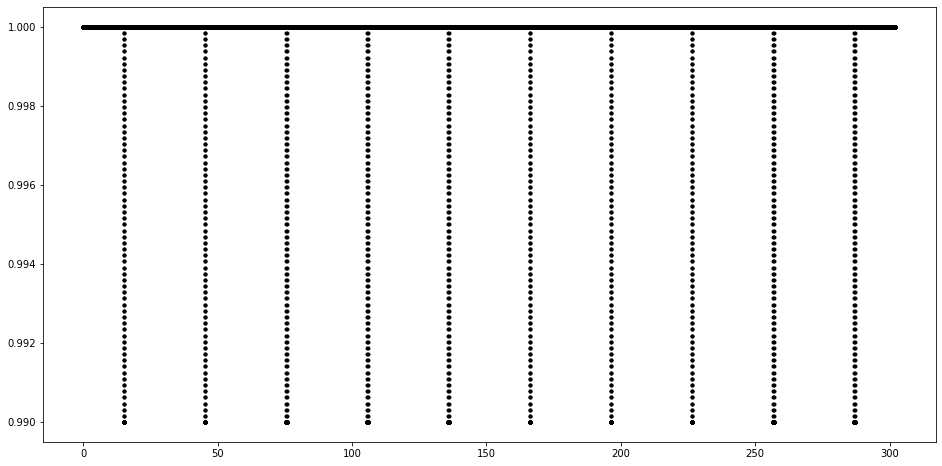

In [27]:
plt.rcParams["figure.figsize"] = (16,8)
tam = 16

plt.plot(time, PT, '.k')
plt.show()

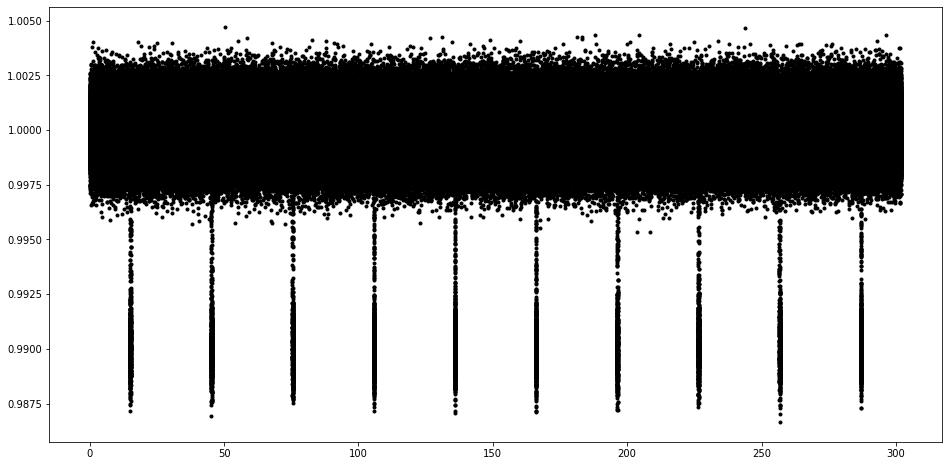

In [28]:
''' Noisy time series '''

stdnoise = 0.0006
fs = len(time)
noise = fgn(n=fs, hurst=0.500001)

# Noisy PT time series
nPT = PT + noise;
plt.plot(time, nPT, '.k')

## Modulação Rotacional

In [29]:
''' Input parameter '''

gamma1 = 0.3985
gamma2 = 0.2586

# ap, bp and cp are the coefficients that give us the bolometric specific intesity
# of the photoshere as a function of the limb angle adopting a quadratic
# limb-darkening law
ap = 1 - gamma1 - gamma2
bp = gamma1 + 2*gamma2
cp = -gamma2

cs = 0.850      # it id a coefficient specifying the spot bolometric contrast
cf0 = 1.115
Q = 0.5         # it is a function of the phase of the solar cycle
As = 0.01       # it is the spot area of the ith active region in unit of the solar surface

ii = ai*np.pi/180 # inclination angle with respect to the line of sight
theta = 0.17*np.pi # it is the position of an active region on star (e.g., 30 deg)

Peq = 15 # in days
AmpliP = 0.2 # alpha=DeltaPer/Per
P2 = Peq*(1 - AmpliP*(np.sin(theta))**2)**(-1)
lambda_ = 2*np.pi/5

In [30]:
''' Spot 1 '''

omega = 2*np.pi/Peq # the angular velocity of the star
c = (ap+2*bp/3+cp/2)**(-1);
mii = np.cos(ii)*np.cos(theta) + np.sin(ii)*np.sin(theta)*np.cos(lambda_ + omega*np.linspace(0,time[-1],len(time)))   # angle of limb

cf = cf0*(1-mii)  # contrast intensity of faculae
s1 = 1 + (As)*(ap+bp*mii + cp*mii**2)*c*((Q*cf - cs)*mii)

''' Spot 2 '''
omega = 2*np.pi/P2
mii = np.cos(ii)*np.cos(theta) + np.sin(ii)*np.sin(theta)*np.cos(lambda_ + omega*np.linspace(0,time[-1],len(time)))   # angle of limb

cf = cf0*(1 - mii)    # contrast intensity of faculae
s2 = 1 + (As)*(ap + bp*mii + cp*mii**2)*c*((Q*cf-cs)*mii)

spots=(s1+s2)-np.mean(s1+s2)

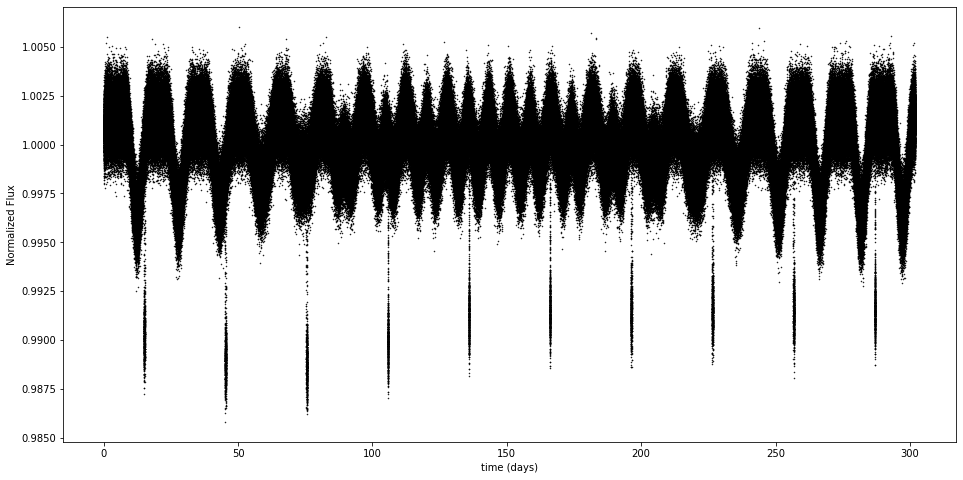

In [32]:
''' whole time series '''
wts = spots+nPT

plt.plot(time, wts, '.k', markersize=1)
plt.xlabel('time (days)')
plt.ylabel('Normalized Flux')
plt.show()